# Hyper Parameter Optimization For ExtraRandomTrees

In [1]:
# import libraries
import os
import sys
import numpy as np
import pandas as pd
# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
MODEL_NAME = 'ExtraRandomTrees'

In [2]:
current_path = os.getcwd()
current_path

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/qiujiangwen441/code/Users/qiujiangwen44/Band-gap-predict/SingleModels/ExtraRandomTrees'

In [3]:
# To import the custom module from a specific path
sys.path.insert(0, os.path.join(current_path, '../../'))
# Importing the custom module
from Utools.draw import plot_feature_importance, plot_feature_importance
from Utools.SingleModel import SingleModel

In [4]:
from sklearn.base import clone
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV

## Load Data

In [5]:
# Load data
file_dir = os.path.join(current_path, '../../Data/composition_data/feature_data')
# dft data
dft_train = pd.read_csv(os.path.join(file_dir, 'dft', 'train.csv'))
dft_test = pd.read_csv(os.path.join(file_dir, 'dft', 'test.csv'))
# exp data
exp_train = pd.read_csv(os.path.join(file_dir, 'exp', 'train.csv'))
exp_test = pd.read_csv(os.path.join(file_dir, 'exp', 'test.csv'))

dft_train_X = dft_train.drop(columns=['composition', 'band_gap'])
dft_train_y = dft_train['band_gap']
exp_train_X = exp_train.drop(columns=['composition', 'band_gap'])
exp_train_y = exp_train['band_gap']
dft_test_X = dft_test.drop(columns=['composition', 'band_gap'])
dft_test_y = dft_test['band_gap']
exp_test_X = exp_test.drop(columns=['composition', 'band_gap'])
exp_test_y = exp_test['band_gap']

## Model Train

### DFT Model

In [6]:
# using grid search to find the best hyperparameters for the dft model
print(f"['DFT {MODEL_NAME}'] HP optimazation begin...")
# define the parameter grid for model
param_distributions = {
    'n_estimators': [100, 200],  # number of trees in the forest
    'max_depth': [None, 5, 10],  # maximum depth of the tree, None means nodes are expanded until all leaves are pure
    'min_samples_split': [2, 5, 10],  # minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],    # minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2', 0.25, 0.5, 1]  # number of features to consider when looking for the best split, None means all features
}

# create a KFold object for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
# create an model
extra_trees = ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1)
# create a GridSearchCV object
random_search = RandomizedSearchCV(estimator=extra_trees, param_distributions=param_distributions,
                n_iter=90, cv=kf, verbose=2, random_state=RANDOM_SEED, 
                scoring='neg_mean_squared_error', return_train_score=True, n_jobs=-1)

# fit the model to the training data
random_search.fit(dft_train_X, dft_train_y)

['DFT ExtraRandomTrees'] HP optimazation begin...
Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV] END max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.3s
[CV] END max_depth=5, max_features=0.25, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   9.5s
[CV] END max_depth=None, max_features=0.25, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  54.0s
[CV] END max_depth=None, max_features=1, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   5.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   5.5s
[CV] END max_depth=None, max_features=0.25, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  53.9s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END max_depth=5, max_features=0.25, min_sa

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=ExtraTreesRegressor(n_jobs=-1, random_state=42),
                   n_iter=90, n_jobs=-1,
                   param_distributions={'max_depth': [None, 5, 10],
                                        'max_features': ['sqrt', 'log2', 0.25,
                                                         0.5, 1],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200]},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_squared_error', verbose=2)

In [7]:
# get the best hyperparameters
best_params = random_search.best_params_
print(f"Best Hyperparameters: {best_params}")
best_score = np.sqrt(-random_search.best_score_)
print(f"Best Cross-Validation RMSE: {best_score:.4f}")

# create a DataFrame to store the results
results = pd.DataFrame(random_search.cv_results_)
results['test_rmse'] = np.sqrt(-results['mean_test_score'])
results['train_rmse'] = np.sqrt(-results['mean_train_score'])
# sort the results by test RMSE
results_sorted = results.sort_values('test_rmse')
results_sorted = results_sorted[['rank_test_score', 'param_n_estimators', 'param_max_depth', 
                                 'param_min_samples_split', 'param_min_samples_leaf', 'param_max_features', 'train_rmse', 'test_rmse']]
# save the results to a csv file
results_sorted.to_csv(os.path.join(current_path, 'dft_random_search_results.csv'), index=False)
results_sorted.head()

Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.5, 'max_depth': None}
Best Cross-Validation RMSE: 0.7209


rank_test_score  param_n_estimators param_max_depth  \
19                1                 100            None   
79                2                 100            None   
7                 3                 200            None   
23                4                 100            None   
76                5                 200            None   

    param_min_samples_split  param_min_samples_leaf param_max_features  \
19                        2                       2                0.5   
79                        5                       1               0.25   
7                         5                       2               0.25   
23                        2                       2               0.25   
76                        2                       1                0.5   

    train_rmse  test_rmse  
19    0.277026   0.720852  
79    0.257885   0.726675  
7     0.328184   0.727335  
23    0.307796   0.728681  
76    0.200985   0.731642

### Overfitting check

####################################################################################################
[DFT - ExtraRandomTrees] Training ExtraRandomTrees on DFT data:
----------------------------------------------------------------------------------------------------
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.1s
[Pipeline] ............. (step 2 of 2) Processing model, total=  15.2s
Model training completed!
[Train_error] Evaluating DFT ExtraRandomTrees on DFT train set:


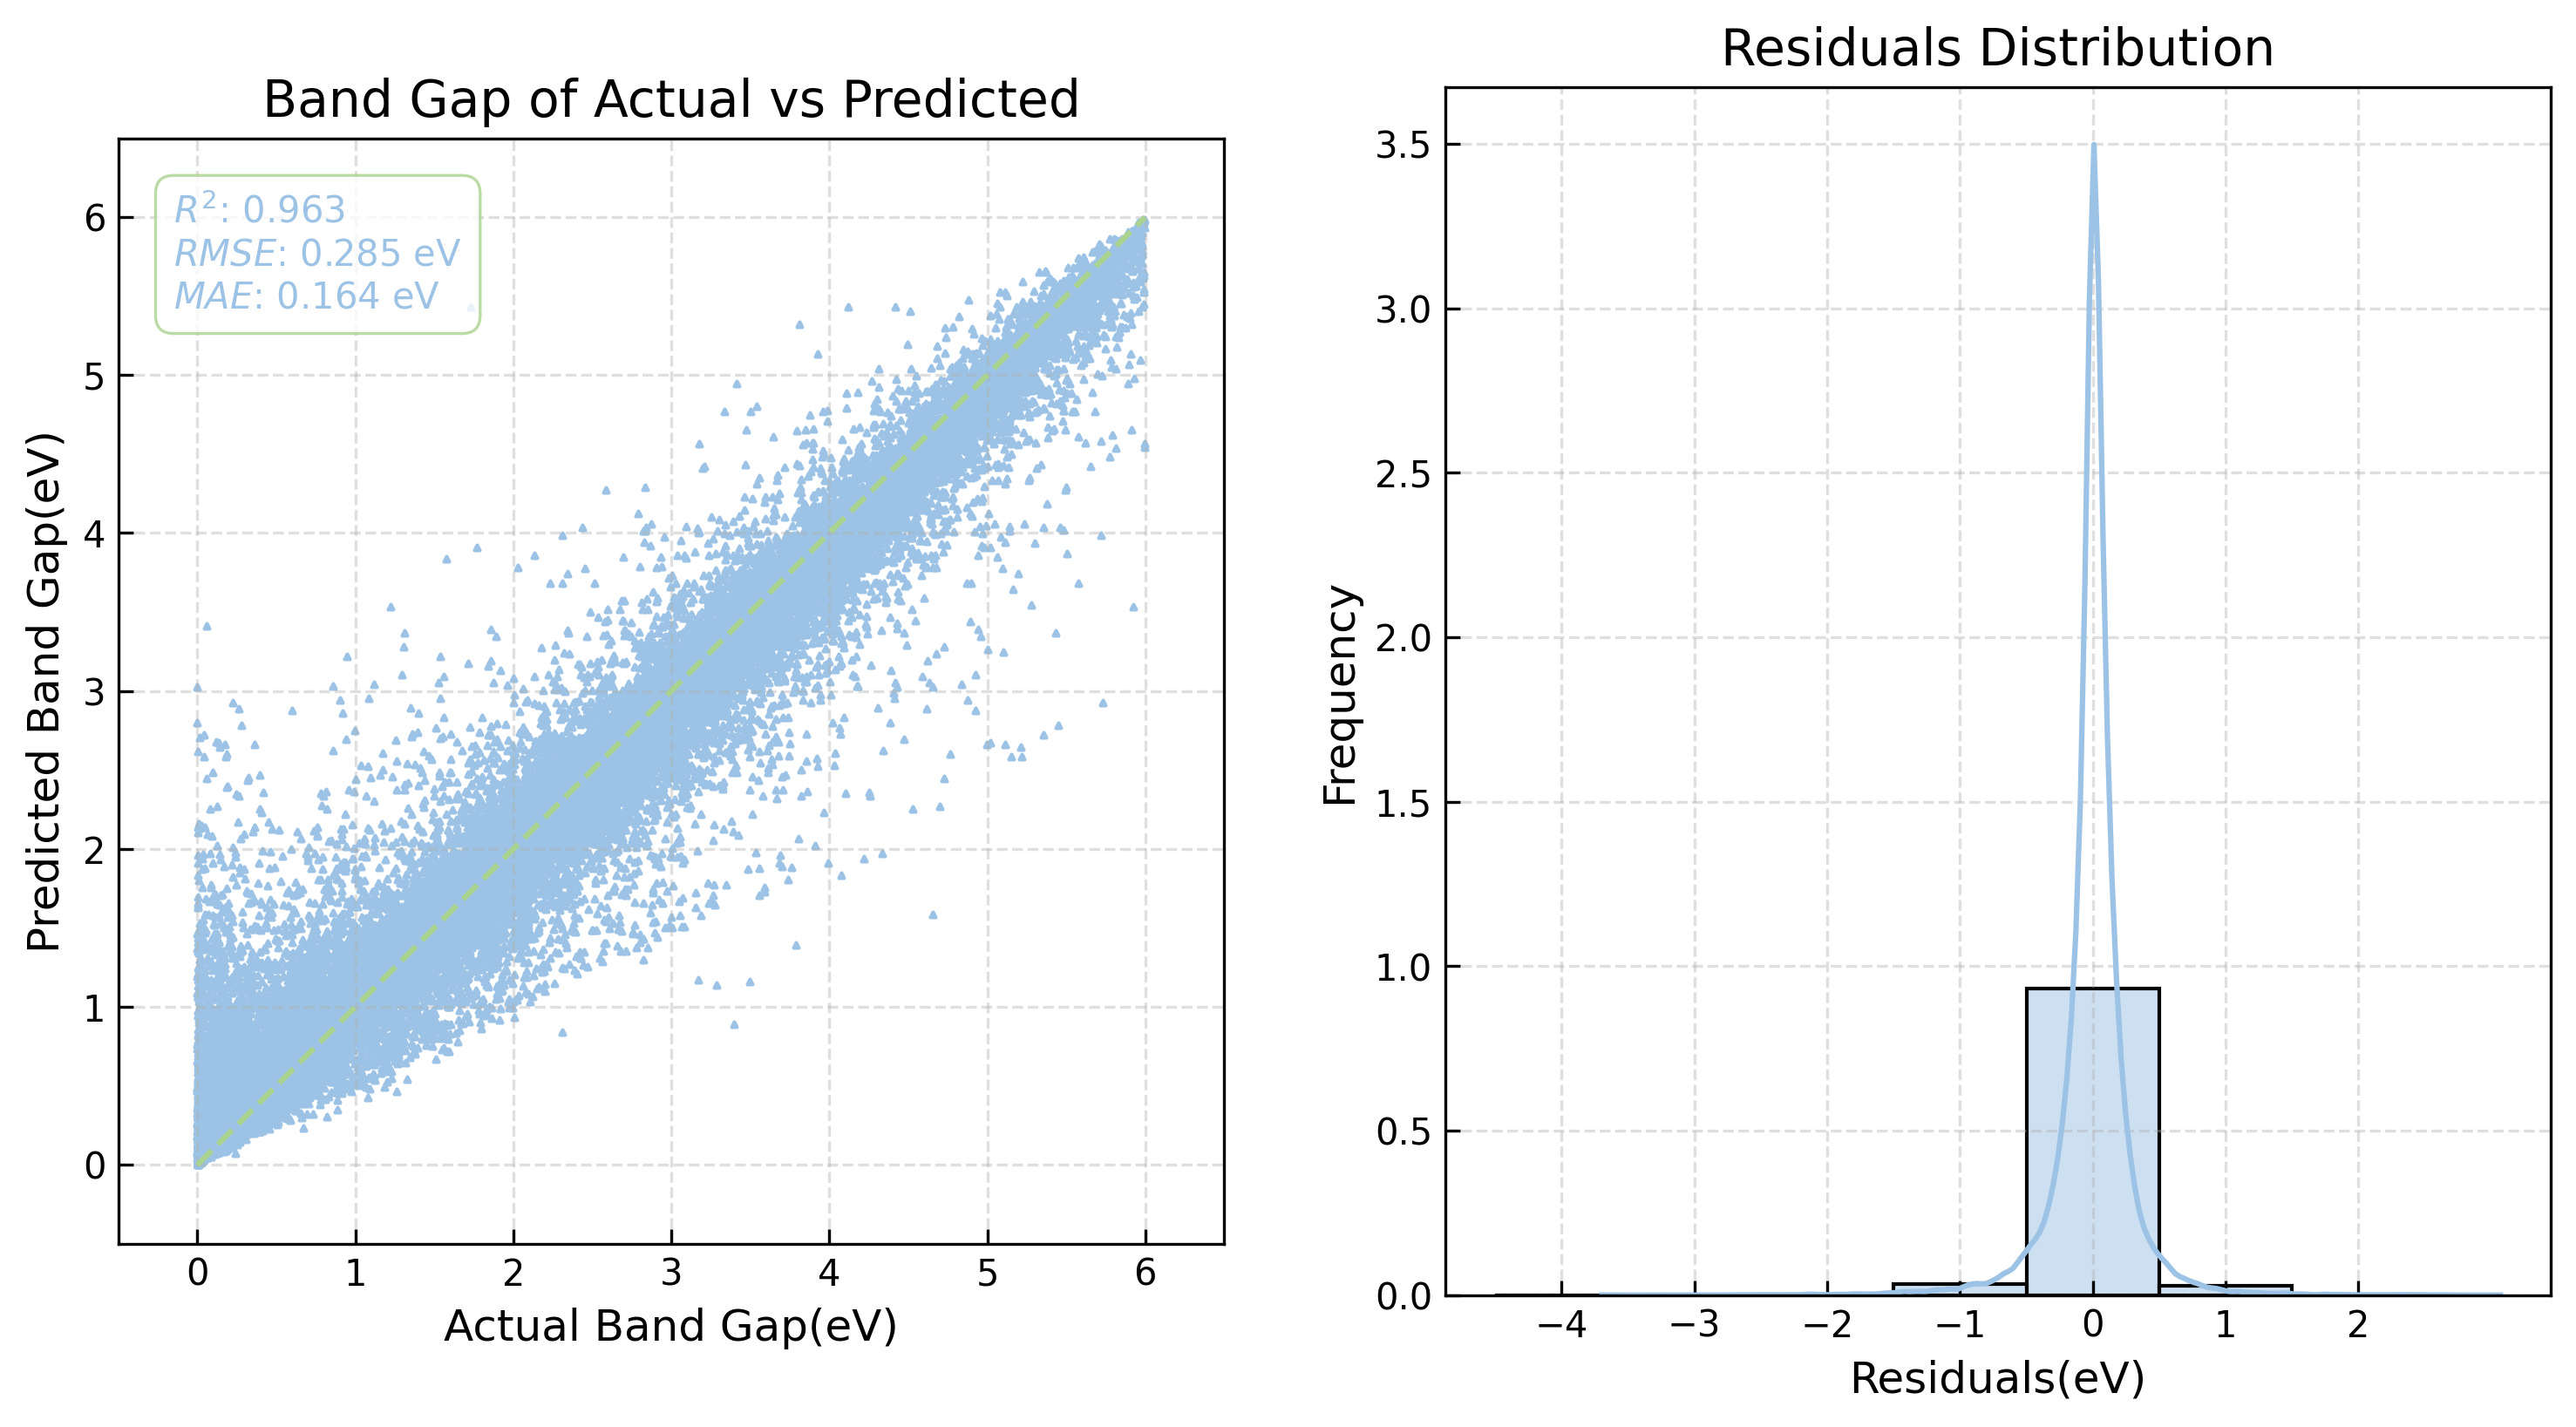


Model Evaluation Results:
Test set: R²: 0.9627 RMSE: 0.2852 MAE: 0.1639
[Test DFT -> DFT] Evaluating DFT ExtraRandomTrees on DFT test set:


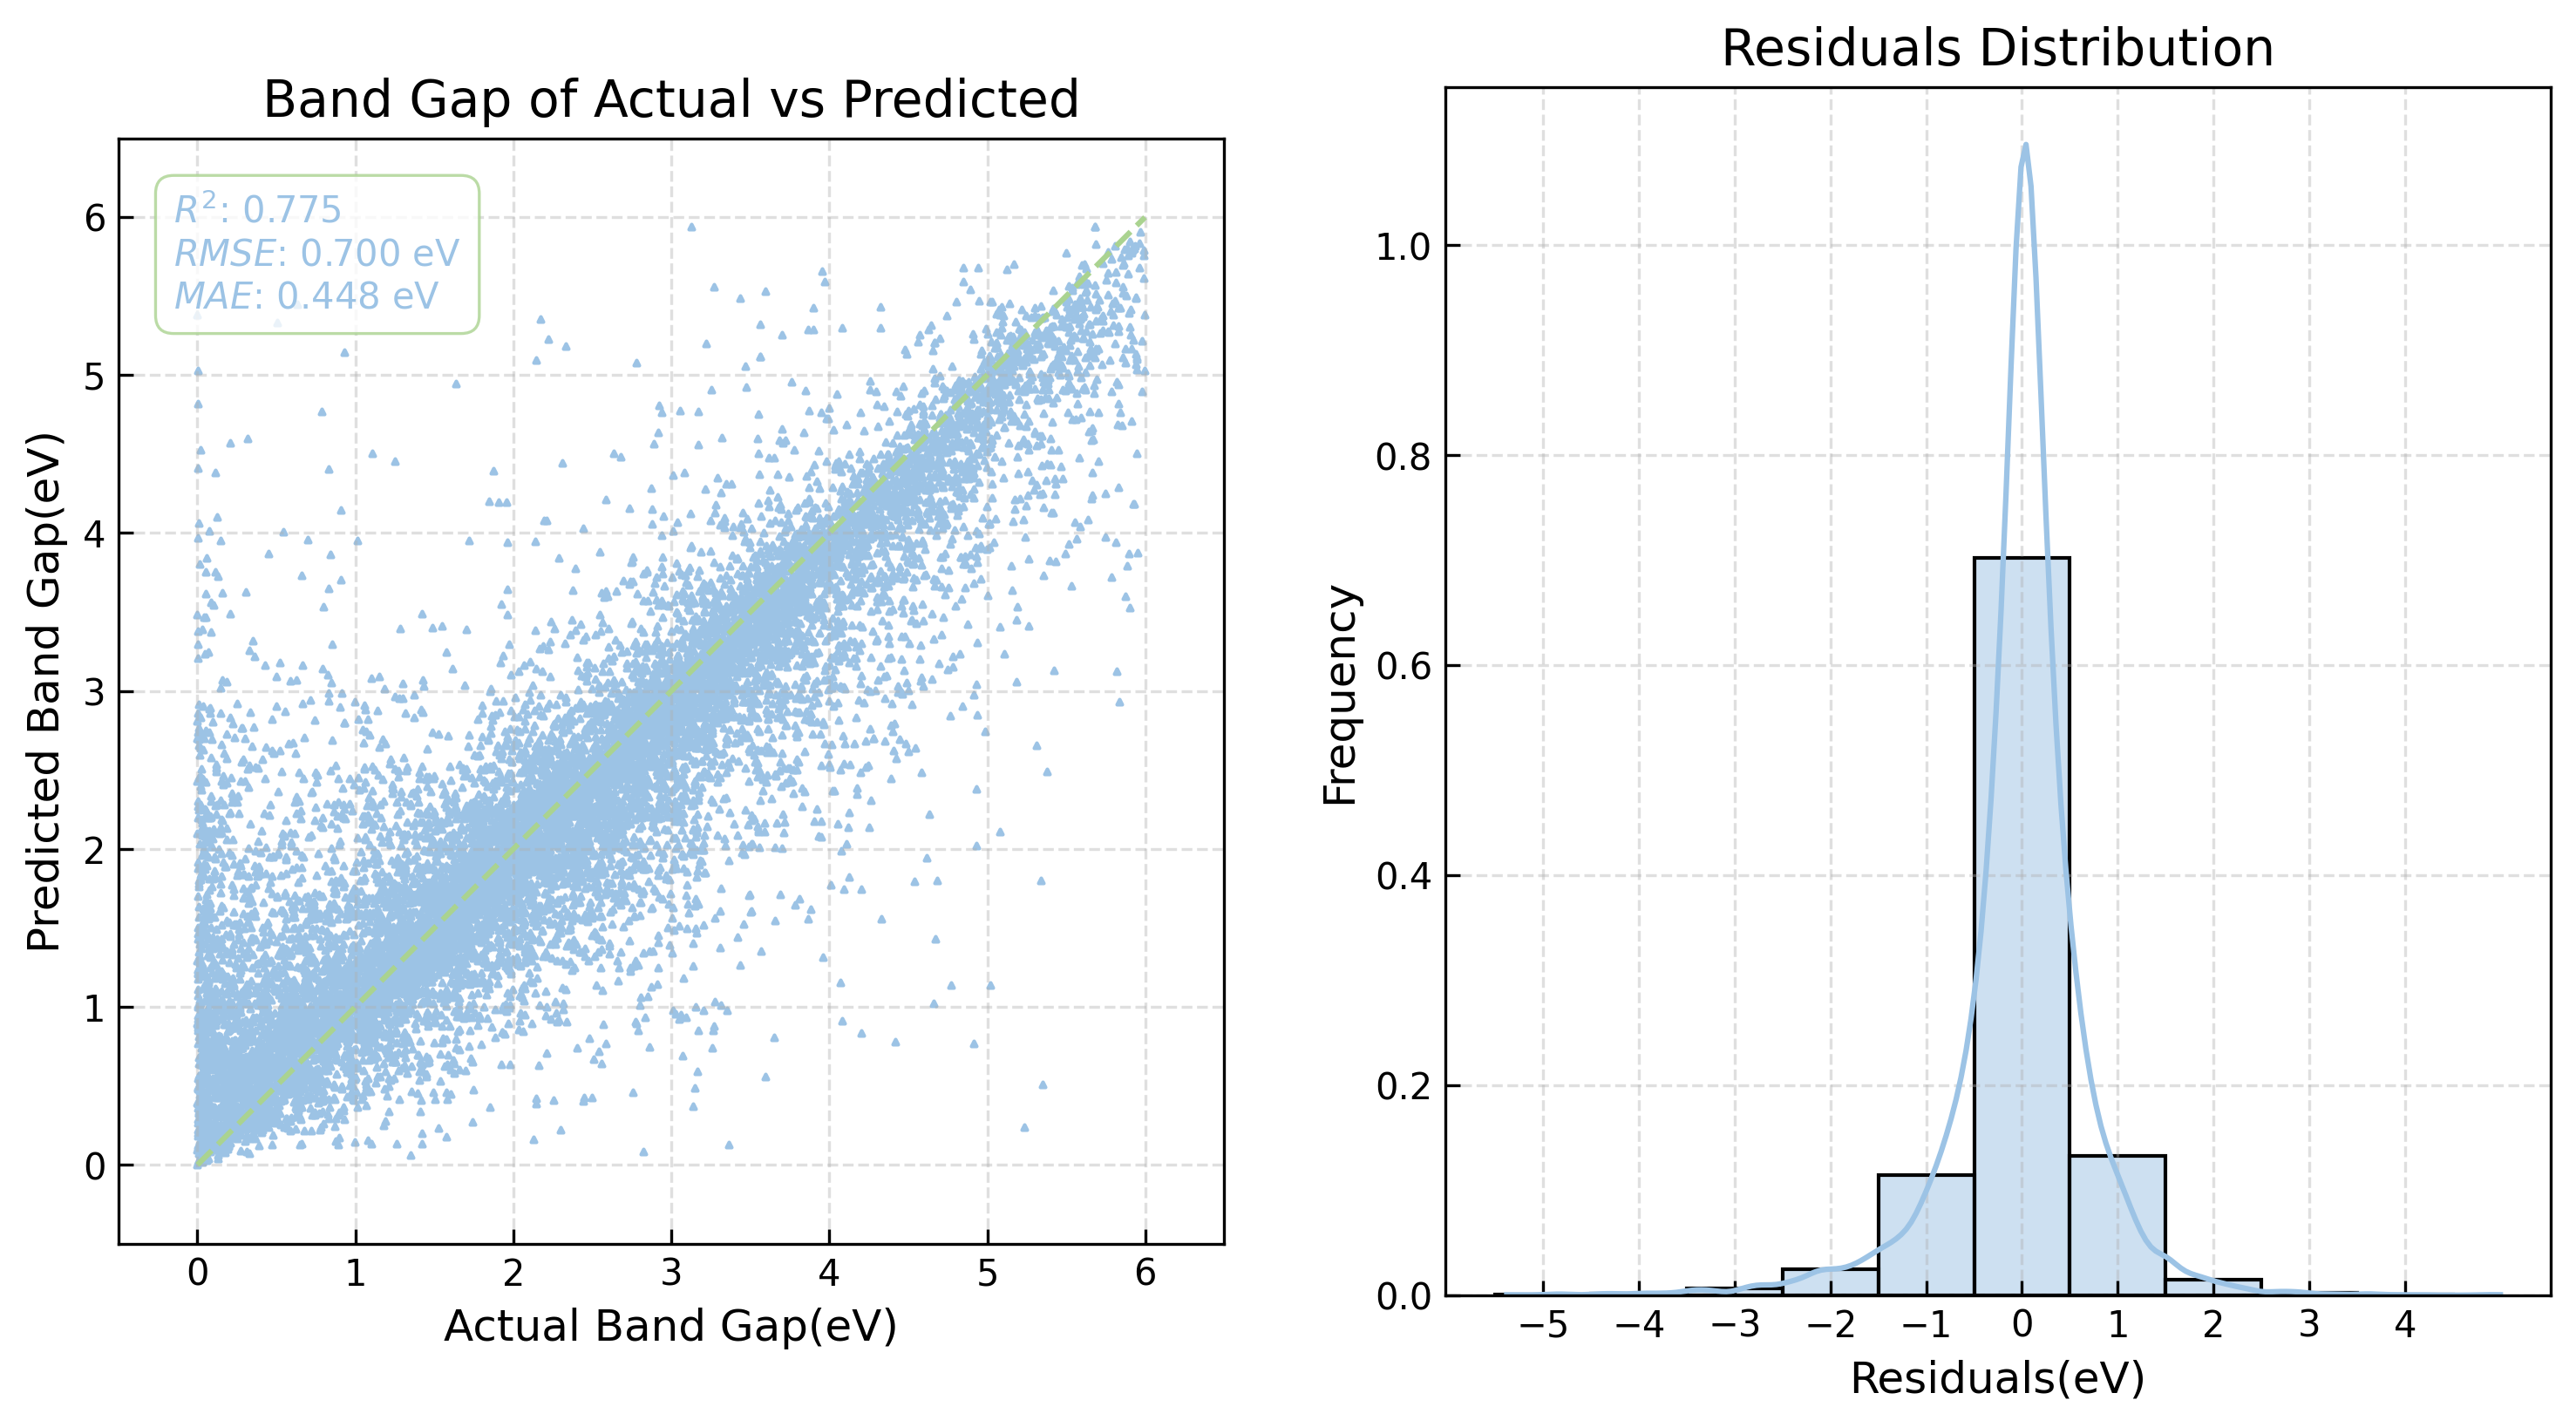


Model Evaluation Results:
Test set: R²: 0.7754 RMSE: 0.7005 MAE: 0.4484
[Test DFT -> EXP] Evaluating DFT ExtraRandomTrees on EXP test set:


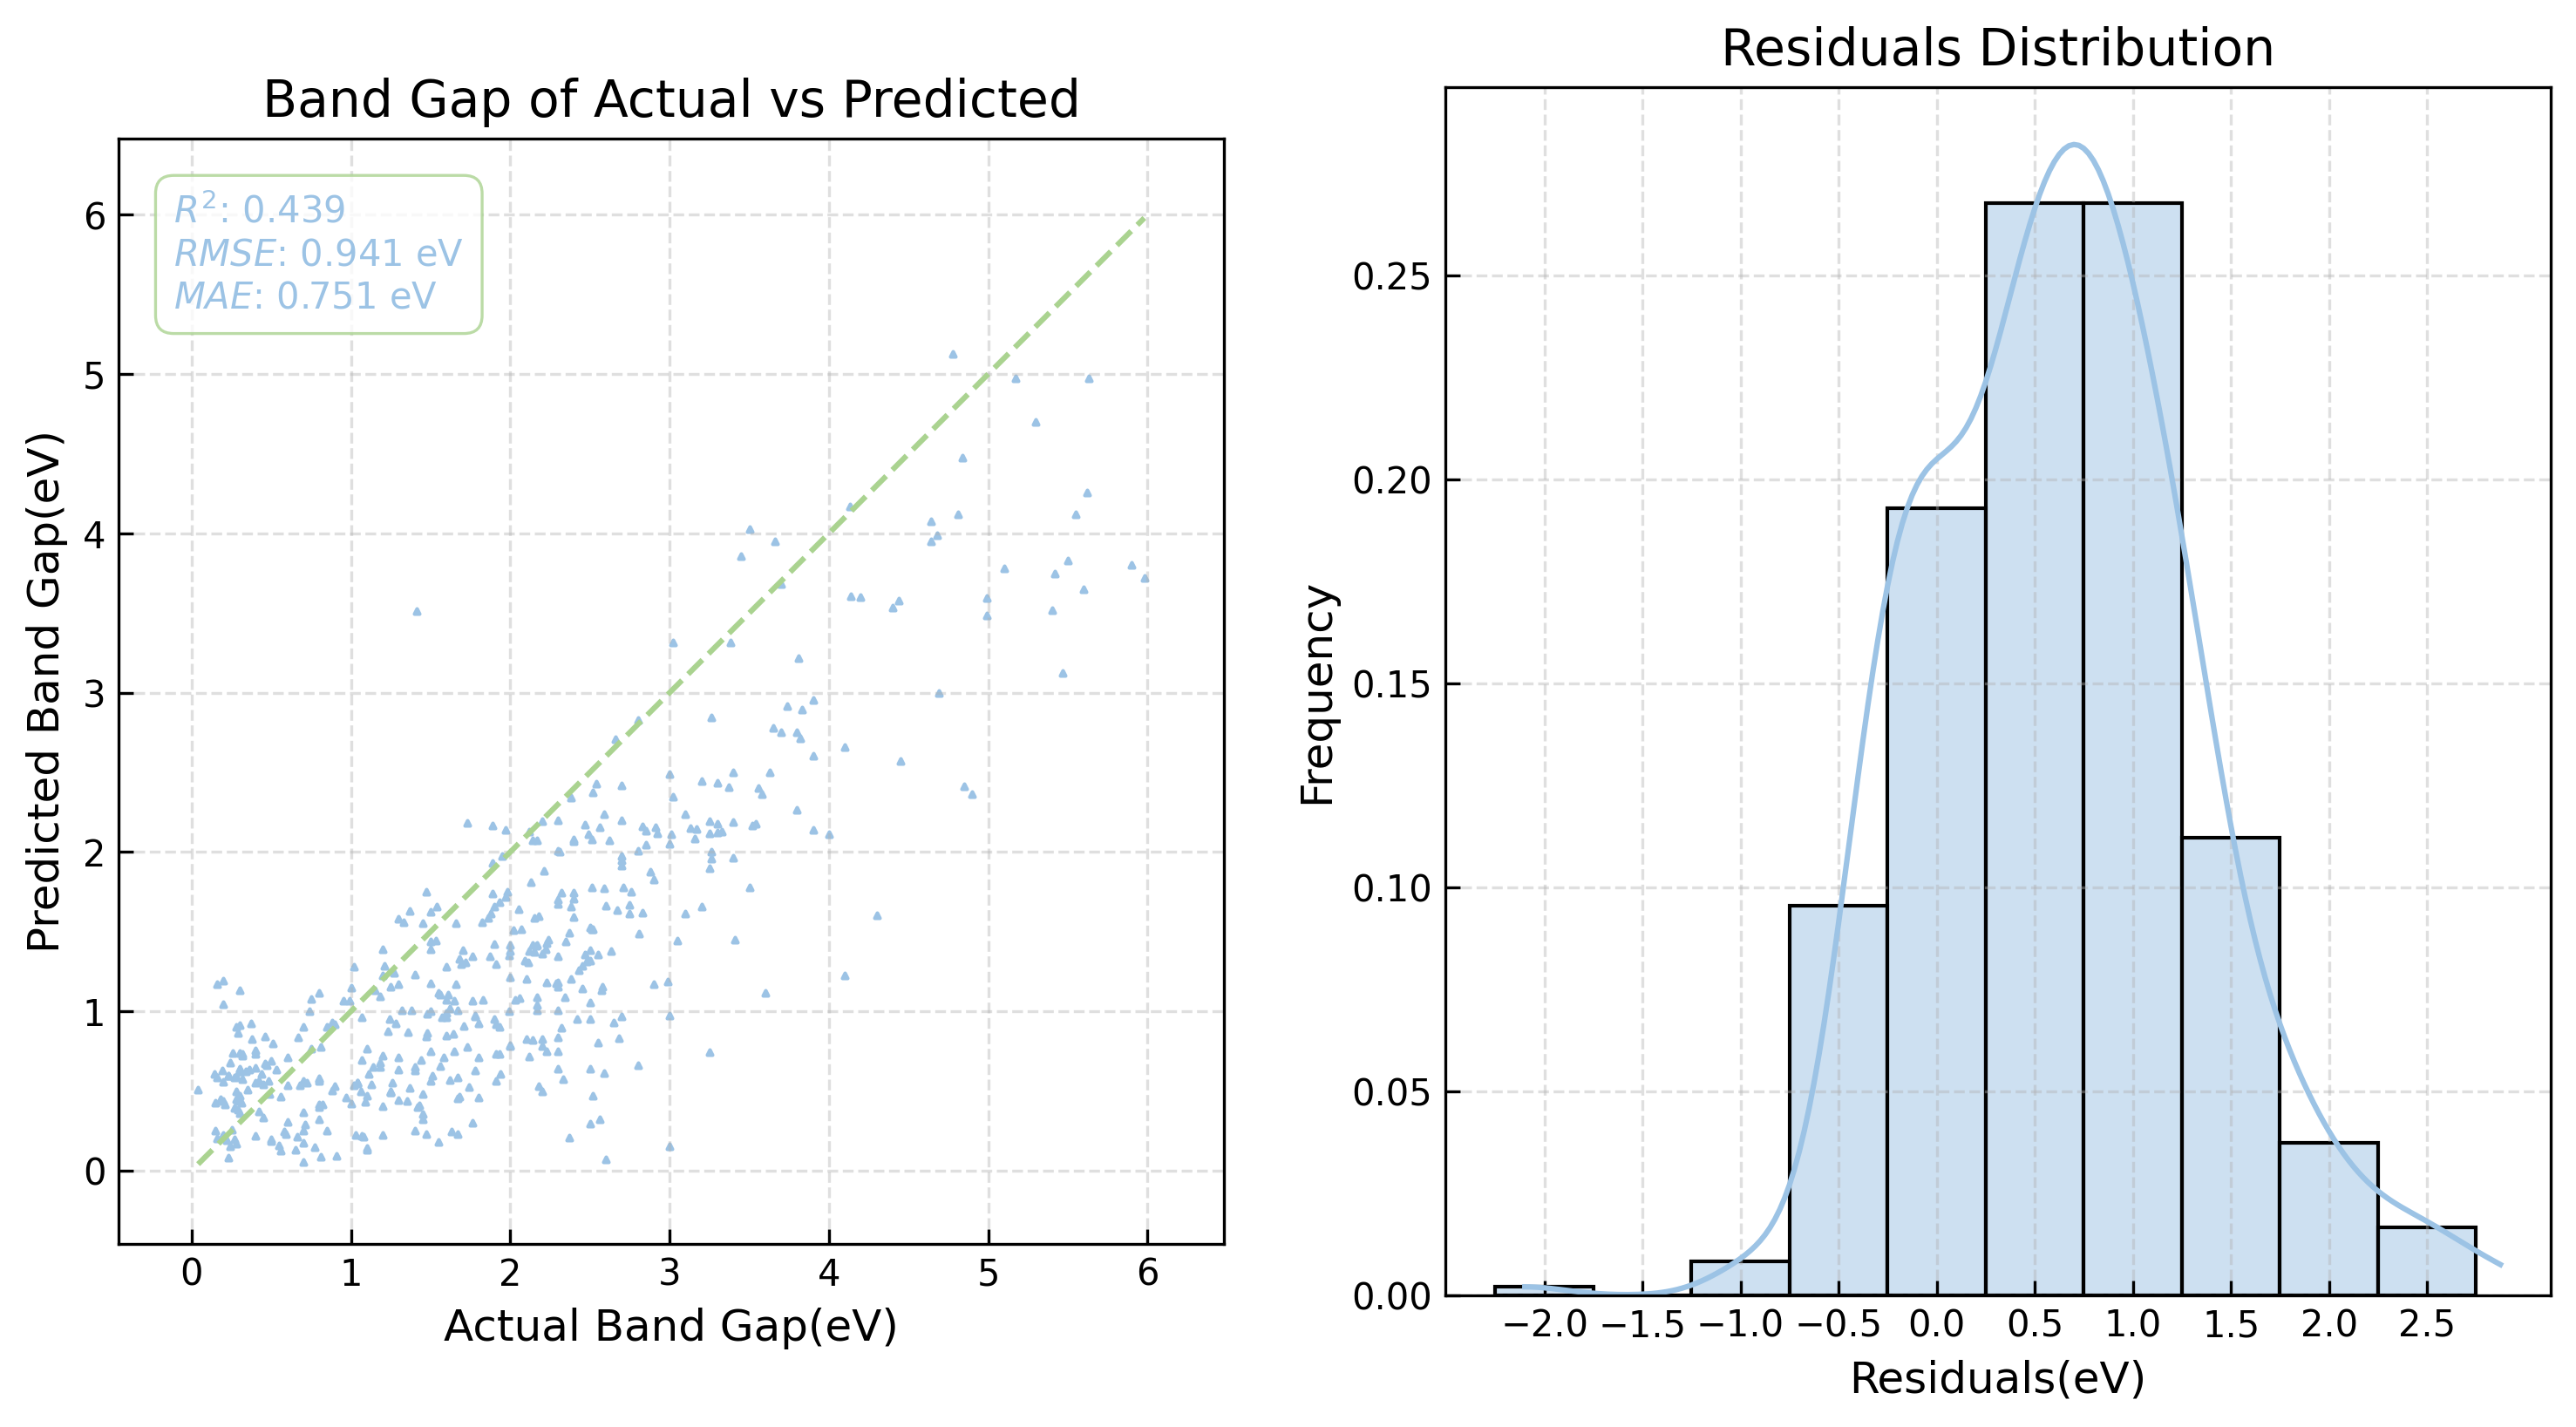


Model Evaluation Results:
Test set: R²: 0.4392 RMSE: 0.9411 MAE: 0.7515


In [17]:
# 
# Train the model with the best hyperparameters on the entire training set
# using the best hyperparameters from the random search
extra_trees_best = ExtraTreesRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features=0.5,
    random_state=RANDOM_SEED,
    n_jobs=-1
)
# record model metrics
model_metrics = pd.DataFrame(columns=['Model', 'Error_Type', 'Train_set', 'Test_set', 'R²', 'RMSE', 'MAE'])
# Train the model on dft data
print("#" * 100)
print(f"[DFT - {MODEL_NAME}] Training {MODEL_NAME} on DFT data:")
print("-" * 100)

dft_model = SingleModel(clone(extra_trees_best), random_state=RANDOM_SEED)
dft_model.train(dft_train_X, dft_train_y)

# evaluate on the dft train set
print(f"[Train_error] Evaluating DFT {MODEL_NAME} on DFT train set:")
metrics = dft_model.evaluate(dft_train_X, dft_train_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Train',
'Train_set': 'dft',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

# evaluate on the dft test set
print(f"[Test DFT -> DFT] Evaluating DFT {MODEL_NAME} on DFT test set:")

metrics = dft_model.evaluate(dft_test_X, dft_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'dft',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}
# evaluate on the exp test set
print(f"[Test DFT -> EXP] Evaluating DFT {MODEL_NAME} on EXP test set:")
metrics = dft_model.evaluate(exp_test_X, exp_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'dft',
'Test_set': 'exp',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

In [18]:
model_metrics.head()

Model Error_Type Train_set Test_set        R²      RMSE  \
0  ExtraRandomTrees      Train       dft      dft  0.962700  0.285186   
1  ExtraRandomTrees       Test       dft      dft  0.775421  0.700483   
2  ExtraRandomTrees       Test       dft      exp  0.439160  0.941119   

        MAE  
0  0.163859  
1  0.448405  
2  0.751460

### EXP Model

In [19]:
# using grid search to find the best hyperparameters for the dft model
print(f"['EXP {MODEL_NAME}'] HP optimazation begin...")
# define the parameter grid for model
param_distributions = {
    'n_estimators': [200, 300, 500],  # number of trees in the forest
    'max_depth': [None, 5, 10, 50],  # maximum depth of the tree, None means nodes are expanded until all leaves are pure
    'min_samples_split': [2, 4, 5, 8],  # minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 3, 4],    # minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2', 0.25, 0.5, 1]  # number of features to consider when looking for the best split, None means all features
}

# create a KFold object for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
# create an model
extra_trees = ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1)
# create a GridSearchCV object
random_search = RandomizedSearchCV(estimator=extra_trees, param_distributions=param_distributions,
                n_iter=300, cv=kf, verbose=2, random_state=RANDOM_SEED, 
                scoring='neg_mean_squared_error', return_train_score=True,  n_jobs=-1)

# fit the model to the training data
random_search.fit(exp_train_X, exp_train_y)

['EXP ExtraRandomTrees'] HP optimazation begin...
Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[CV] END max_depth=5, max_features=1, min_samples_leaf=4, min_samples_split=8, n_estimators=200; total time=   0.3s
[CV] END max_depth=50, max_features=0.5, min_samples_leaf=3, min_samples_split=4, n_estimators=500; total time=   3.4s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=300; total time=   0.6s
[CV] END max_depth=10, max_features=0.25, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.2s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   1.5s
[CV] END max_depth=50, max_features=1, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END max_depth=50, max_features=0.5, min_sample

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=ExtraTreesRegressor(n_jobs=-1, random_state=42),
                   n_iter=300, n_jobs=-1,
                   param_distributions={'max_depth': [None, 5, 10, 50],
                                        'max_features': ['sqrt', 'log2', 0.25,
                                                         0.5, 1],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [2, 4, 5, 8],
                                        'n_estimators': [200, 300, 500]},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_squared_error', verbose=2)

In [20]:
# get the best hyperparameters
best_params = random_search.best_params_
print(f"Best Hyperparameters: {best_params}")
best_score = np.sqrt(-random_search.best_score_)
print(f"Best Cross-Validation RMSE: {best_score:.4f}")

# create a DataFrame to store the results
results = pd.DataFrame(random_search.cv_results_)
results['test_rmse'] = np.sqrt(-results['mean_test_score'])
results['train_rmse'] = np.sqrt(-results['mean_train_score'])
# sort the results by test RMSE
results_sorted = results.sort_values('test_rmse')
results_sorted = results_sorted[['rank_test_score', 'param_n_estimators', 'param_max_depth', 
                                 'param_min_samples_split', 'param_min_samples_leaf', 'param_max_features', 'train_rmse', 'test_rmse']]
# save the results to a csv file
results_sorted.to_csv(os.path.join(current_path, 'exp_random_search_results.csv'), index=False)
results_sorted.head()

Best Hyperparameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5, 'max_depth': 50}
Best Cross-Validation RMSE: 0.5714


rank_test_score  param_n_estimators param_max_depth  \
183                1                 500              50   
123                2                 200              50   
220                3                 300            None   
293                4                 300            None   
88                 5                 200            None   

     param_min_samples_split  param_min_samples_leaf param_max_features  \
183                        2                       1                0.5   
123                        2                       1                0.5   
220                        2                       1               0.25   
293                        4                       1                0.5   
88                         2                       1               0.25   

     train_rmse  test_rmse  
183    0.012254   0.571396  
123    0.012254   0.572147  
220    0.012254   0.572668  
293    0.073218   0.573147  
88     0.012254   0.573483

### Overfitting check

####################################################################################################
[EXP - ExtraRandomTrees] Training ExtraRandomTrees on EXP data:
----------------------------------------------------------------------------------------------------
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.4s
Model training completed!
[Train_error] Evaluating EXP ExtraRandomTrees on EXP train set:
[Test EXP -> EXP] Evaluating EXP ExtraRandomTrees on EXP test set:


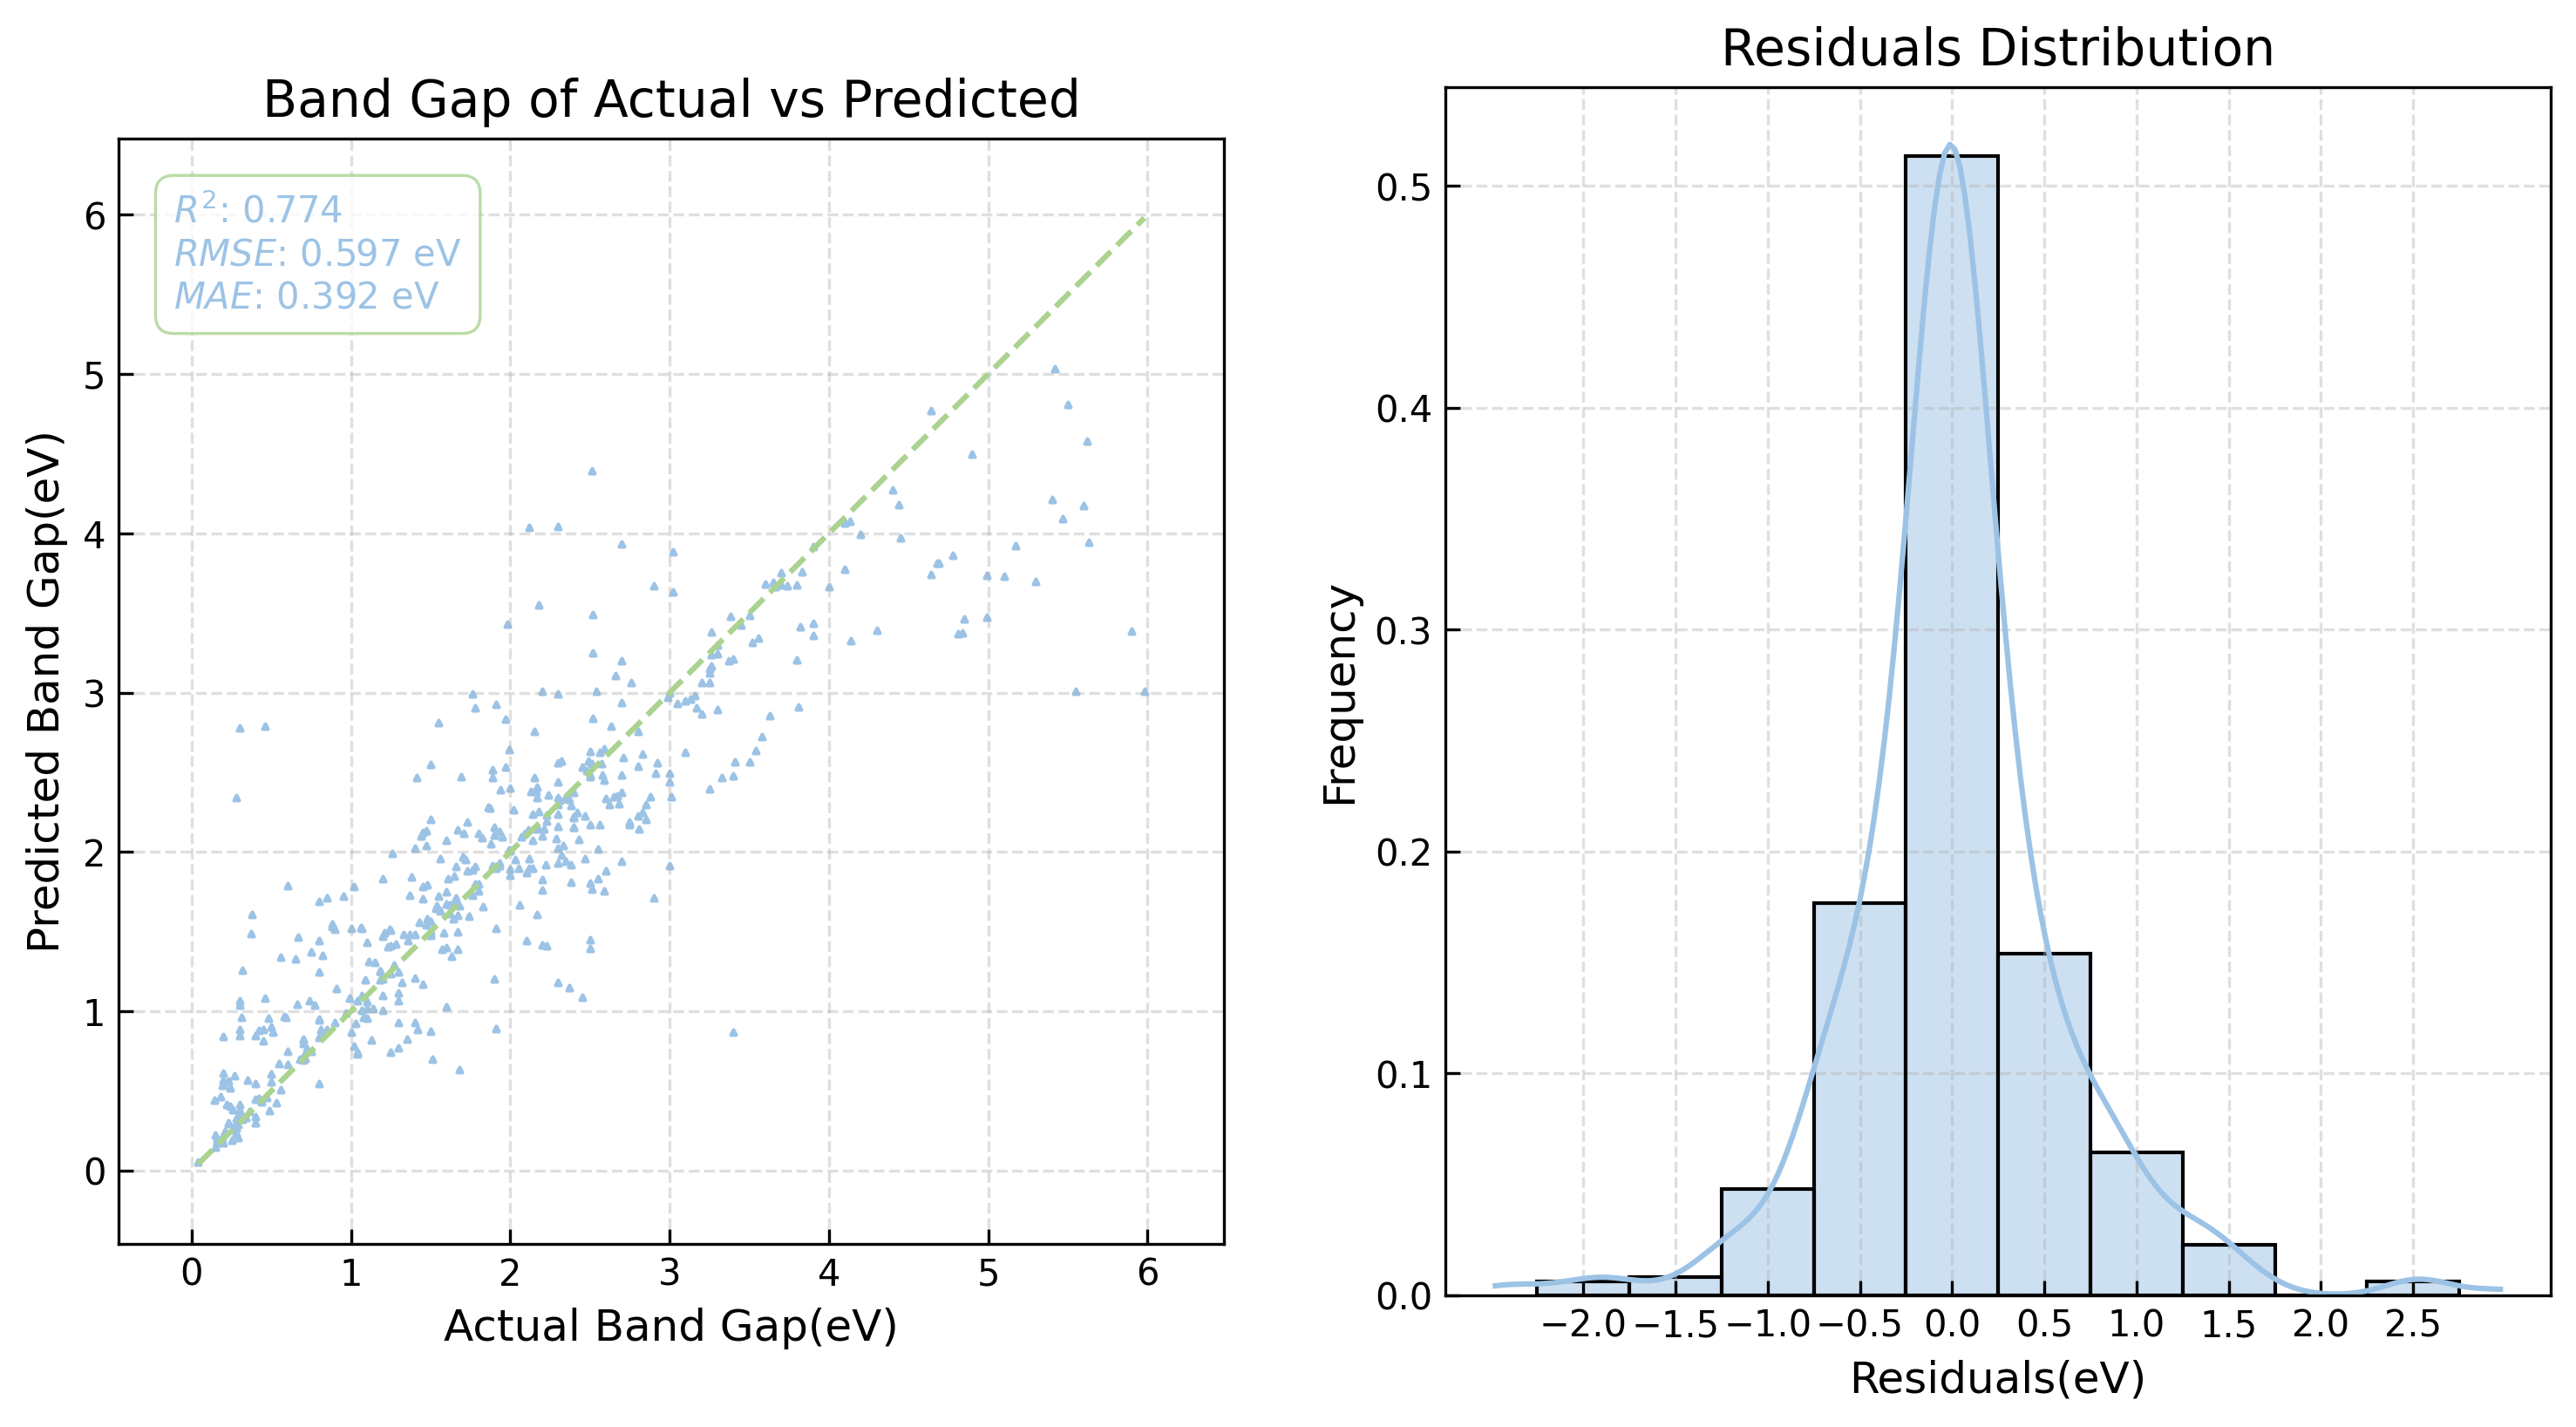


Model Evaluation Results:
Test set: R²: 0.7744 RMSE: 0.5968 MAE: 0.3918
[Test EXP -> DFT] Evaluating EXP ExtraRandomTrees on DFT test set:


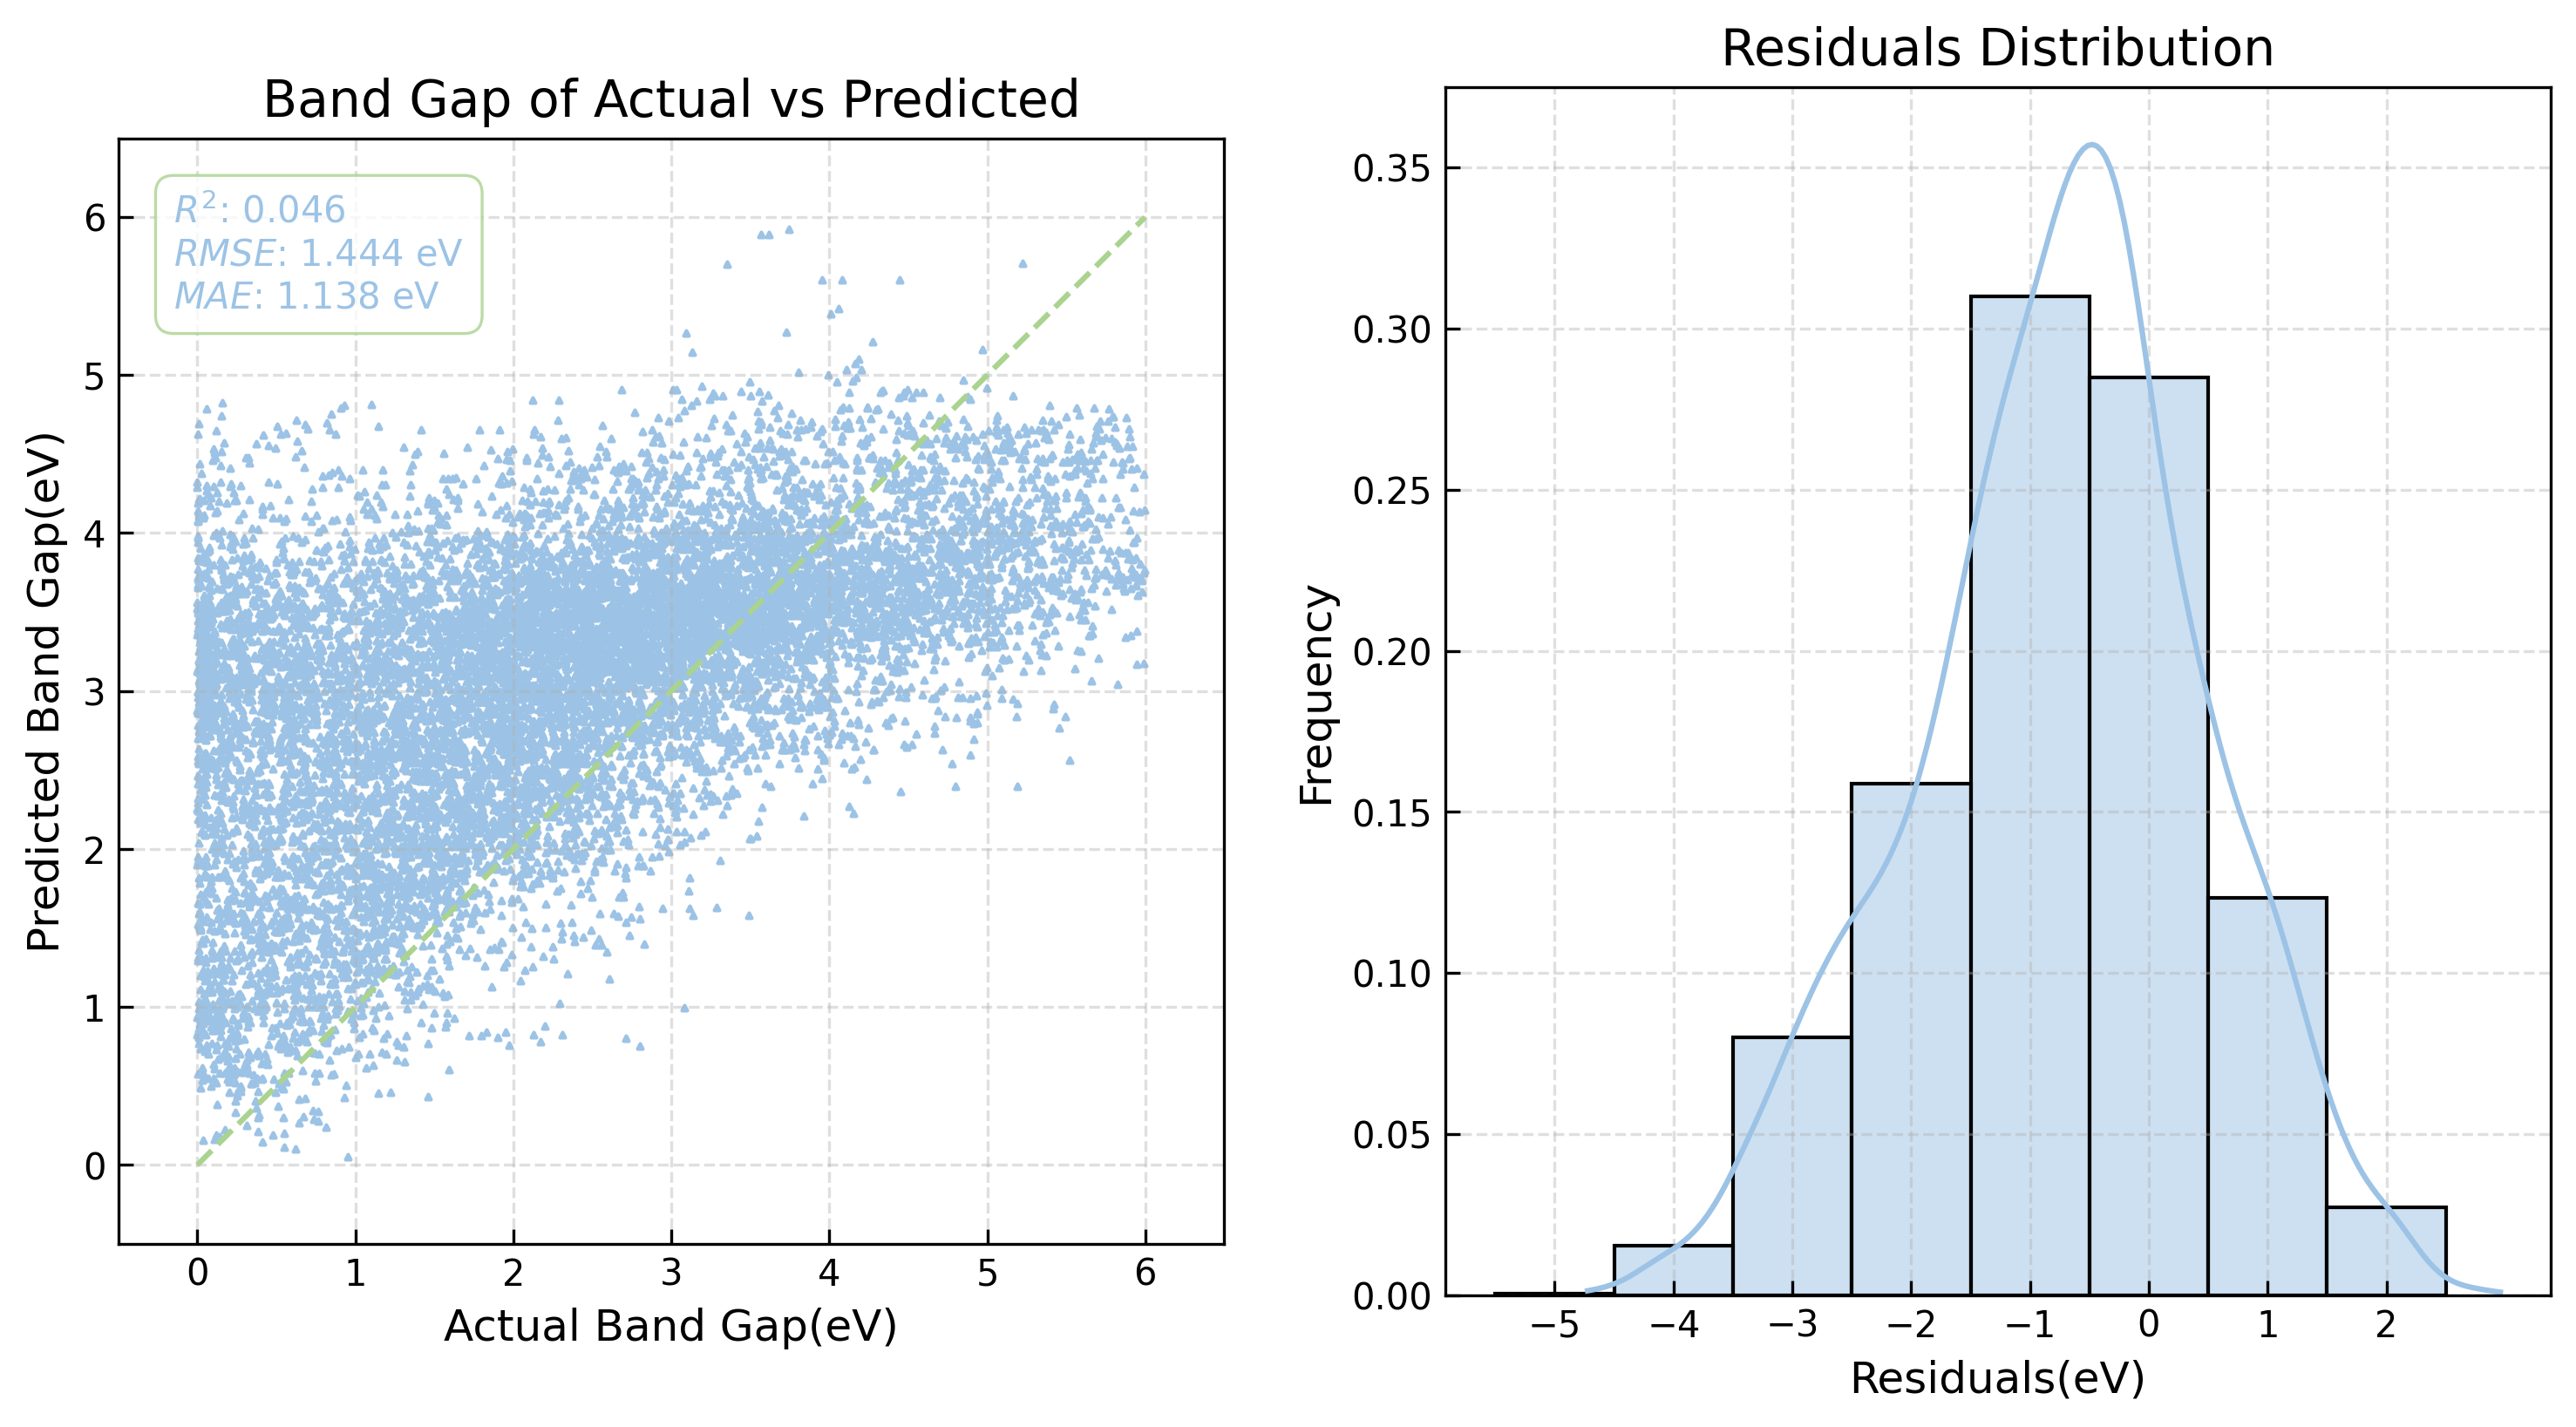


Model Evaluation Results:
Test set: R²: 0.0458 RMSE: 1.4438 MAE: 1.1380


In [28]:
# 
# Train the model with the best hyperparameters on the entire training set
# using the best hyperparameters from the random search
extra_trees_best = ExtraTreesRegressor(
    n_estimators=200,
    max_depth=50,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=0.5,
    random_state=RANDOM_SEED,
    n_jobs=-1
)
# record model metrics
model_metrics = pd.DataFrame(columns=['Model', 'Error_Type', 'Train_set', 'Test_set', 'R²', 'RMSE', 'MAE'])
# Train the model on dft data
print("#" * 100)
print(f"[EXP - {MODEL_NAME}] Training {MODEL_NAME} on EXP data:")
print("-" * 100)

exp_model = SingleModel(clone(extra_trees_best), random_state=RANDOM_SEED)
exp_model.train(exp_train_X, exp_train_y)

# evaluate on the dft train set
print(f"[Train_error] Evaluating EXP {MODEL_NAME} on EXP train set:")
# metrics = exp_model.evaluate(exp_train_X, exp_train_y)
# model_metrics.loc[len(model_metrics)] = {
# 'Model': MODEL_NAME,
# 'Error_Type': 'Train',
# 'Train_set': 'exp',
# 'Test_set': 'exp',
# 'R²': metrics['r2'],
# 'RMSE': metrics['rmse'],
# 'MAE': metrics['mae']
# }

# evaluate on the dft test set
print(f"[Test EXP -> EXP] Evaluating EXP {MODEL_NAME} on EXP test set:")

metrics = exp_model.evaluate(exp_test_X, exp_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'exp',
'Test_set': 'exp',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}
# evaluate on the exp test set
print(f"[Test EXP -> DFT] Evaluating EXP {MODEL_NAME} on DFT test set:")
metrics = exp_model.evaluate(dft_test_X, dft_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'exp',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

In [29]:
model_metrics.head()

Model Error_Type Train_set Test_set        R²      RMSE  \
0  ExtraRandomTrees       Test       exp      exp  0.774430  0.596850   
1  ExtraRandomTrees       Test       exp      dft  0.045846  1.443849   

        MAE  
0  0.391808  
1  1.138001